In [1]:
base_dir = '../results/'
dir_anes = base_dir + 'anes/'
anes_data = base_dir + 'anes_timeseries_2016.dta'

In [2]:
from tqdm import tqdm
import numpy as np
import pandas as pd

import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

import sys
sys.path.append('..')

In [3]:
from plot_utils.models import hf_models, model_names, model_sizes
models = sorted(hf_models, key=lambda x: model_sizes[x])

### Load model responses

In [4]:
features = {
    'V161342': 'gender',  # gender
    'V161310x': 'race',  # race
    'V161270': 'education',  # education
    'V161267': 'age', # age
    'V161244': 'religion', # 'church',  # Attends Church
    'V162125x': 'patriotism', #'flag',  # Patriotism
    'V162174': 'politics_discuss', # 'discuss_pol',  # Discusses politics
    'V162256': 'politics_interest', #'pol_interest',  # Political interest
    'V162031x': 'voted_2016', # 'voted',  # voted 2016
    'V162062x': 'voted_2016_candidate', # 'vote_choice', # 2016 Vote Choice 
    'V161126':  'political_ideology', #'ideology',  # Ideology
    'V161158x': 'partisan_identification', # 'party_id' # Party ID
}

# Data from model responses
model_data = {}
n_seeds = 2
for model in models:
    dfs = []
    for seed in range(n_seeds):
        fname = f"{dir_anes}{model}_s{seed}.csv"
        dfs.append(pd.read_csv(fname))
    data = pd.concat(dfs, ignore_index=True)
    model_data[model] = data[features.values()]

### Load human responses

In [5]:
data = pd.read_stata(anes_data)
data = data[features]

valid_choices = {'V161342': [1, 2],
                 'V161310x': [1, 2, 3, 5],
                 'V161270': [[5, 6, 7, 8, 9], 10, [11, 12, 13], [14, 15, 16]],
                 'V161244': [1, 2],
                 'V162125x': [1, 2, 3, 4, 5, 6, 7],
                 'V162174': [1, 2],
                 'V162256': [1, 2, 3, 4],
                 'V162031x': [2, 1],
                 'V161126': [1, 2, 3, 4, 5, 6, 7],
                 'V161158x': [1, 2, 3, 4, 5, 6, 7]
                 }

for col, idx in valid_choices.items():
    valid_idx = []
    column_vals = []
    
    for i, val in enumerate(data[col]):
        if val[0] != '-':
            n = int(val.split('.')[0])
            for j, idx_ in enumerate(idx):
                if (type(idx_) == list and n in idx_) or n == idx_:
                    column_vals.append(j)
                    valid_idx.append(i)
                    break
    
    data = data.iloc[valid_idx]
    data[features[col]] = pd.Series(column_vals)
    

# Process age
ages = []
ages_valid = []
for i, val in enumerate(data['V161267']):
    if type(val) == float:
        ages_valid.append(i)
        ages.append(val)
    elif val[0] != '-':
        ages_valid.append(i)
        ages.append(int(val.split('.')[0]))
        
# Discretize 
bins = [4, 15, 30, 40, 50, 64]
ages_coded = []
for val in ages:
    if val > bins[-1]:
        ages_coded.append(len(bins)-1)
    else:
        for j, v in enumerate(bins):
            if val <= v:
                ages_coded.append(j)
                break
                
data = data.iloc[ages_valid]
data[features['V161267']] = pd.Series(ages_coded)

data = data.dropna()

# Process vote choice
coded = []
not_valid = []
for i, val in enumerate(data['V162062x']):
    if val[:2] == '1.':
        coded.append(0)
    elif val[:2] == '2.':
        coded.append(1)
    elif val[:2] in ['3.', '4.', '5.']:
        coded.append(2)
    elif val[:2] == '-2':
        coded.append(np.nan)
    else:
        not_valid.append(i)
        
valid = [i for i in range(len(data)) if i not in not_valid]
data = data.iloc[valid]
data[features['V162062x']] = pd.Series(coded)
data = data[features.values()]

/var/folders/6b/g5148_j17tzcrm8qq__90y_w0000gn/T/ipykernel_11029/3375660721.py:1: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  data = pd.read_stata(anes_data)
/var/folders/6b/g5148_j17tzcrm8qq__90y_w0000gn/T/ipykernel_11029/3375660721.py:2: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  data = data[features]


### Perform the discriminator test

In [6]:
n_seeds = 10
data['SYNTH'] = 0
model_acc = {m: [] for m in models}
for model_name in tqdm(models):
    for seed in range(n_seeds):
        data_model = model_data[model_name].sample(n=len(data), random_state=seed)
        data_model['SYNTH'] = 1

        all_data = pd.concat([data_model, data])
        all_data = all_data.sample(n=len(all_data), random_state=seed)

        Y = all_data['SYNTH']
        X = all_data.drop(columns=['SYNTH'])
        X = X.fillna(0).astype('Int64')

        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)

        model = XGBClassifier()
        model.fit(X_train, y_train)
        model_acc[model_name].append(np.mean(model.predict(X_test) == y_test))

100%|██████████| 29/29 [00:35<00:00,  1.24s/it]


[0.5749595745760656, 0.4453617714151208, 0.8381404052084455, 0.0, 0.4545454545454519, 0.4165977904505285, 0.8576346483687816, 0.6363636363636327, 0.8331955809010633, 0.7100226978096917, 0.6803013430498037, 0.8181818181818136, 0.7100226978096916, 0.4453617714151208, 0.5821022034029829, 0.36363636363636154, 0.7272727272727231, 0.7100226978096917, 0.48956043701222474, 0.7100226978096917, 0.4453617714151208, 0.7925270806437589, 0.6803013430498037, 0.7100226978096917, 0.7272727272727231, 0.6098367211363027, 0.7100226978096917, 0.8576346483687821, 0.6030226891555237]


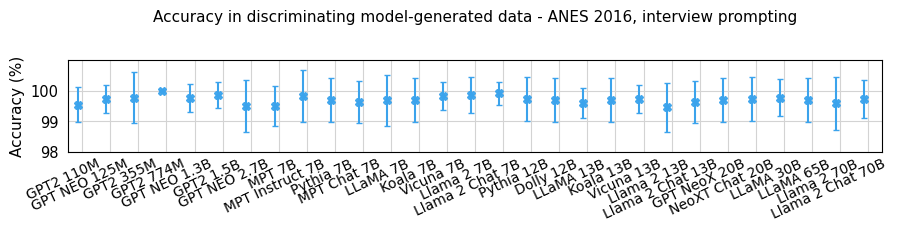

In [7]:
import matplotlib.pyplot as plt
from plot_utils.plot_utils import plot_discriminator
plot_discriminator(model_acc, None, models, model_names,
                  title="Accuracy in discriminating model-generated data - ANES 2016, interview prompting")
plt.ylim([98, 101])
plt.yticks([98, 99, 100])
plt.savefig('../plots/discriminator_test_anes.pdf', bbox_inches='tight')